# Определение возраста покупателей

Задача проекта - построение модели, которая по фотографии определит приблизительный возраст человека.
В нашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
                                                   directory='/datasets/faces/final_files/',
                                                   x_col='file_name',
                                                   y_col='real_age',
                                                   target_size=(224, 224),
                                                   batch_size=16,
                                                   class_mode='raw',
                                                   seed=12345
                                                  ) 

Found 7591 validated image filenames.


In [3]:
labels

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


<br>В проекте стоит задача распознования фотографий - размер выборки повлияет на скорость обучения модели, также можно получить ошибку о нехватке памяти.
<br>Т.к. обучение нейронных сетей на центральном процессоре занимает много времени, особенно в случае решения задач компьютерного зрения, то, чтобы существенно ускорить процесс, все вычисления для проекта предложено производить на сервере с графической картой.
<br>Считаю, что для того, чтобы научить машину определять возвраст человека чем больше фотографий для примера, тем лучше, и в нашем датасете данных достаточно, чтобы научить модель определять примерный возвраст.

Text(0.5, 1.0, 'Гистограмма распределения возраста на фотографиях')

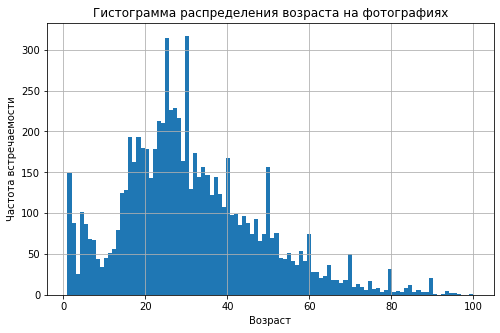

In [4]:
plt.figure(figsize=(8, 5))

labels['real_age'].hist(bins=100, range=(1, 100))

plt.xlabel('Возраст')
plt.ylabel('Частота встречаемости')

plt.title('Гистограмма распределения возраста на фотографиях')

<br>Из графика видно, что распределение скошено в правую сторону. Можно сделать вывод, что есть два пика возраста: 0-3 и 20-30 лет, фотографий людей в возрасте 20-30 лет больше всего.
<br>Следует обратить внимание на пики в возрасте 40, 50, 60, 70 и т.д. лет. Возможно это связано с тем, что возраст был округлен.

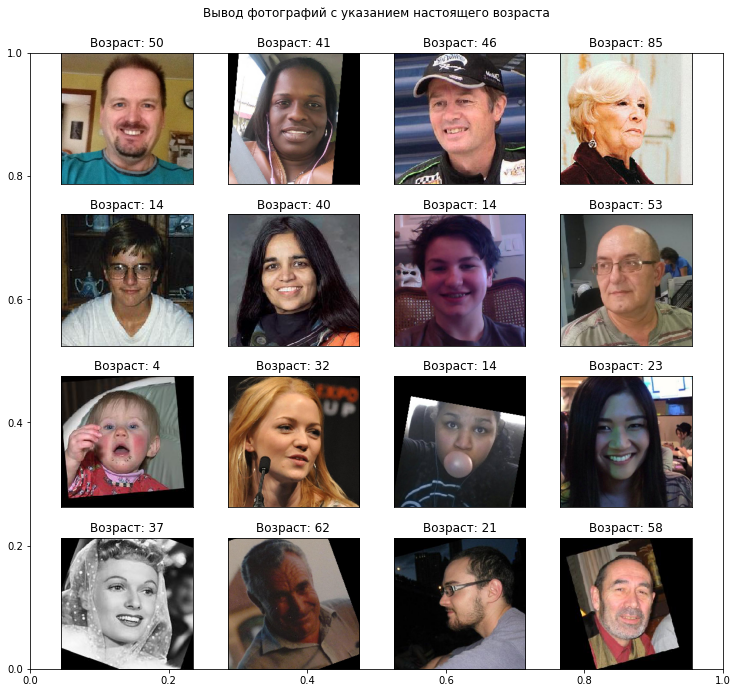

In [5]:
features, target = next(train_gen_flow)

# выводим 16 изображений
fig = plt.figure(figsize=(10, 10))

plt.title('Вывод фотографий с указанием настоящего возраста\n\n')

for i in range(16):
    
    fig.add_subplot(4, 4, i+1)
    
    plt.title('Возраст: ' + str(target[i])) #добавила строку с возрастом
    
    plt.imshow(features[i])
    
    # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()  

In [6]:
features.shape

(16, 224, 224, 3)

Признаки — четырёхмерный тензор, в котором 16 изображений размером 224x224 с тремя цветовыми каналами.
<br>
<br>Общая ориентация фотографий примерно одинакова, на некоторых уже выровнено положение лица, т.е. нет необходимости поворачивать фотографии. На некоторых фотографиях есть черные рамки, которые не несут полезной информации. Начальный размер изображений отличается - заметно различное качество фотографий. Перед обучением модели приведем изображения к единому размеру 224x224.

## Обучение модели

In [7]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [8]:
#загрузка тренировочной выборки
def load_train(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                       horizontal_flip=True,
                                       rescale=1./255
                                      )
    train_gen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
                                                       directory=path + 'final_files/',
                                                       x_col='file_name',
                                                       y_col='real_age',
                                                       target_size=(224, 224),
                                                       batch_size=16,
                                                       class_mode='raw',
                                                       subset='training',
                                                       seed=12345
                                                      )
    return train_gen_flow

#загрузка тестовой выборки
def load_test(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    
    test_datagen = ImageDataGenerator(validation_split=0.25,
                                      rescale=1./255
                                     )
    test_gen_flow = test_datagen.flow_from_dataframe(dataframe=labels,
                                                     directory=path + 'final_files/',
                                                     x_col='file_name',
                                                     y_col='real_age',
                                                     target_size=(224, 224),
                                                     batch_size=16,
                                                     class_mode='raw',
                                                     subset='validation',
                                                     seed=12345
                                                    )
    return test_gen_flow

#создание модели
def create_model(input_shape):
    
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False
                       )

    model = Sequential()
    
    model.add(backbone)
    
    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

#обучение модели
def train_model(model,
                train_data,
                test_data,
                batch_size=None,
                epochs=20,
                steps_per_epoch=None,
                validation_steps=None
               ):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
        
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

Результат вывода на экран обучения этой модели выглядит так:

```
Train for 356 steps, validate for 119 steps
Epoch 1/20
2022-09-10 01:43:41.662687: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-09-10 01:43:43.789147: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 67s - loss: 230.7698 - mae: 10.9312 - val_loss: 534.9103 - val_mae: 18.0774
Epoch 2/20
356/356 - 38s - loss: 84.3095 - mae: 6.9852 - val_loss: 162.3141 - val_mae: 9.7794
Epoch 3/20
356/356 - 38s - loss: 57.0072 - mae: 5.7651 - val_loss: 97.8108 - val_mae: 7.4210
Epoch 4/20
356/356 - 38s - loss: 41.5579 - mae: 4.9329 - val_loss: 74.5056 - val_mae: 6.5599
Epoch 5/20
356/356 - 38s - loss: 32.8201 - mae: 4.3523 - val_loss: 143.3699 - val_mae: 9.6807
Epoch 6/20
356/356 - 38s - loss: 23.5197 - mae: 3.7025 - val_loss: 81.4397 - val_mae: 6.6790
Epoch 7/20
356/356 - 38s - loss: 19.5734 - mae: 3.3439 - val_loss: 65.3551 - val_mae: 5.9893
Epoch 8/20
356/356 - 38s - loss: 15.1934 - mae: 3.0054 - val_loss: 69.6281 - val_mae: 6.0715
Epoch 9/20
356/356 - 38s - loss: 12.6719 - mae: 2.7419 - val_loss: 69.3524 - val_mae: 6.3214
Epoch 10/20
356/356 - 38s - loss: 12.5240 - mae: 2.7063 - val_loss: 65.9009 - val_mae: 5.9870
Epoch 11/20
356/356 - 38s - loss: 12.1493 - mae: 2.6589 - val_loss: 68.7702 - val_mae: 6.2629
Epoch 12/20
356/356 - 38s - loss: 12.4556 - mae: 2.6747 - val_loss: 62.5462 - val_mae: 5.9248
Epoch 13/20
356/356 - 38s - loss: 13.0310 - mae: 2.7367 - val_loss: 64.1206 - val_mae: 5.9874
Epoch 14/20
356/356 - 38s - loss: 12.0242 - mae: 2.6322 - val_loss: 74.8183 - val_mae: 6.4603
Epoch 15/20
356/356 - 38s - loss: 12.4597 - mae: 2.6999 - val_loss: 61.5365 - val_mae: 5.7660
Epoch 16/20
356/356 - 38s - loss: 11.1458 - mae: 2.5217 - val_loss: 92.8811 - val_mae: 7.6757
Epoch 17/20
356/356 - 38s - loss: 10.4014 - mae: 2.4540 - val_loss: 66.3179 - val_mae: 6.0374
Epoch 18/20
356/356 - 38s - loss: 10.0883 - mae: 2.4400 - val_loss: 63.4859 - val_mae: 5.9669
Epoch 19/20
356/356 - 38s - loss: 12.6018 - mae: 2.6516 - val_loss: 71.3929 - val_mae: 6.5309
Epoch 20/20
356/356 - 38s - loss: 10.0892 - mae: 2.3958 - val_loss: 60.9033 - val_mae: 5.7671
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 9s - loss: 60.9033 - mae: 5.7671
Test MAE: 5.7671
```

## Анализ обученной модели

Вывод:
<br>Для исследовательского анализа определения возраста по фотографии была использована модель ResNet50 с одним нейроном на выходе, с указанием функции активации relu и функции оптимизации для нахождения минимума Adam с шагом lr=0.0001, было задано 20 эпох.
<br>На тестовой выборке модель показала значение MAE = 5.7671, а на обучающей 2.3958. Получается, что модель при определении возраста может ошибиться на 3,5 года, но при этом определит приблизительный возраст человека.